In [ ]:
# 1. Import các thư viện cần thiết
import random
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore

import torch # type: ignore
import torch.optim as optim # type: ignore
import torchvision # type: ignore
import torchvision.transforms as transforms # type: ignore
from torch import nn # type: ignore
from torch.utils.data import Dataset, DataLoader, random_split # type: ignore
from torchvision.datasets import FashionMNIST # type: ignore

In [2]:
# 2. Xác định phần cứng và cố định tham số ngẫu nhiên
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(42)

In [3]:
# 3. Tải bộ dữ liệu
train_dataset = FashionMNIST(
                            root='./data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_dataset = FashionMNIST(
                            root='./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.47MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# 4. Chia bộ dữ liệu train/val/test
batch_size = 64
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train size: {len(train_subset)}")
print(f"Val size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Val size: 6000
Test size: 10000


In [ ]:
# 5. Xây dựng mô hình MLP
class MPL(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MPL, self).__init__()
        self.hidden_dims = hidden_dims
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.BatchNorm1d(self.hidden_dims)(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-3

model = MPL(
            input_dims = input_dims,
            hidden_dims = hidden_dims,
            output_dims = output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

In [8]:
# 6. Huấn luyện mô hình
epochs = 40
train_loss_lst = []
val_loss_lst = []
train_acc_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/40, Train_Loss: 0.6773, Train_Acc: 0.8129, Val_Loss: 0.5071, Val_Acc: 0.8265
EPOCH 2/40, Train_Loss: 0.4514, Train_Acc: 0.8440, Val_Loss: 0.4456, Val_Acc: 0.8408
EPOCH 3/40, Train_Loss: 0.4163, Train_Acc: 0.8530, Val_Loss: 0.4393, Val_Acc: 0.8455
EPOCH 4/40, Train_Loss: 0.3920, Train_Acc: 0.8612, Val_Loss: 0.4134, Val_Acc: 0.8532
EPOCH 5/40, Train_Loss: 0.3799, Train_Acc: 0.8641, Val_Loss: 0.4170, Val_Acc: 0.8507
EPOCH 6/40, Train_Loss: 0.3654, Train_Acc: 0.8680, Val_Loss: 0.4191, Val_Acc: 0.8535
EPOCH 7/40, Train_Loss: 0.3555, Train_Acc: 0.8730, Val_Loss: 0.3901, Val_Acc: 0.8593
EPOCH 8/40, Train_Loss: 0.3470, Train_Acc: 0.8745, Val_Loss: 0.3875, Val_Acc: 0.8578
EPOCH 9/40, Train_Loss: 0.3368, Train_Acc: 0.8794, Val_Loss: 0.3792, Val_Acc: 0.8653
EPOCH 10/40, Train_Loss: 0.3307, Train_Acc: 0.8808, Val_Loss: 0.3970, Val_Acc: 0.8592
EPOCH 11/40, Train_Loss: 0.3253, Train_Acc: 0.8816, Val_Loss: 0.3990, Val_Acc: 0.8623
EPOCH 12/40, Train_Loss: 0.3173, Train_Acc: 0.8844, Val_Loss: 0

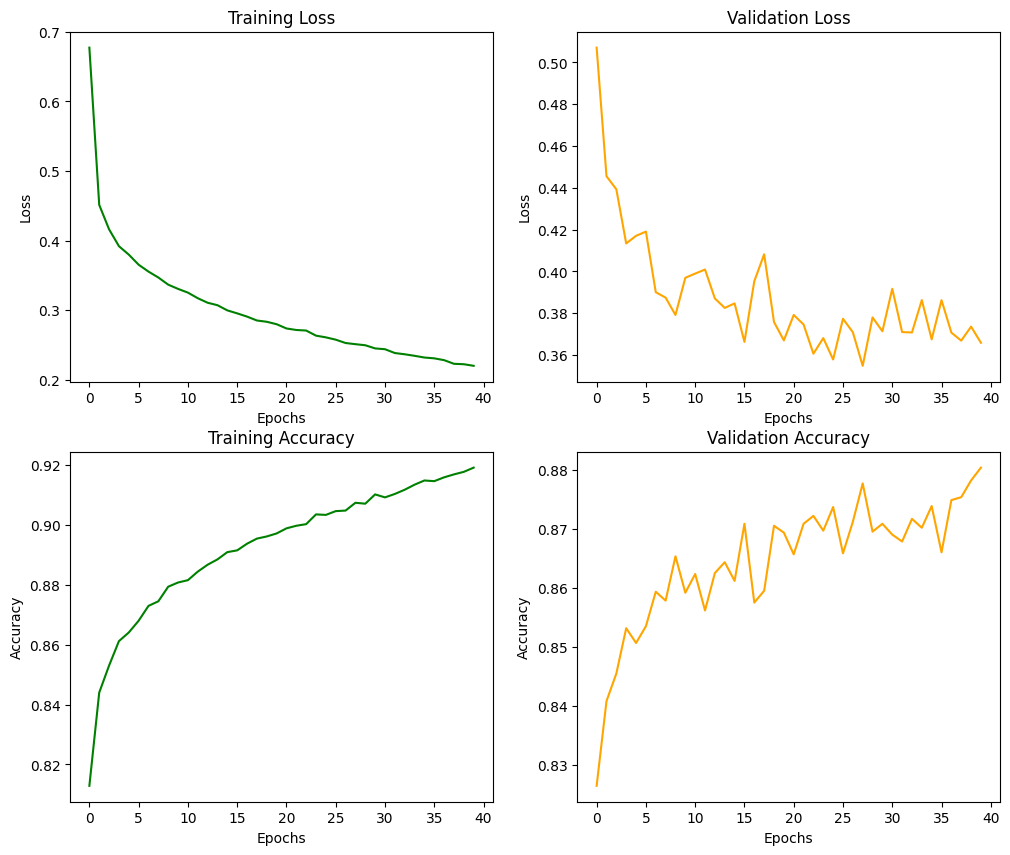

In [9]:
# 7. Trực quan hóa kết quả huấn luyện
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color = 'green')
ax[0, 0].set(xlabel='Epochs', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color = 'orange')
ax[0, 1].set(xlabel='Epochs', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color = 'green')
ax[1, 0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color = 'orange')
ax[1, 1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [10]:
# 8. Đánh giá mô hình
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')


Evaluation on test set:
Accuracy: 0.8715
